In [1]:
import json
import os
import yaml
import importlib
from pathlib import Path
import datetime
import shutil
import utils

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd 
from scipy import interp


from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc


from torch import utils
# import pytorch_lightning as pl
import lightning.pytorch as pl

import model.StNN_index as stnn_index
import model.StNN_static as stnn

from utils import statics_from_config
from dataset.datasets_wrapped import TransferData, WeatherDataset
from build_model import load_multi_model
from utils_data import generate_clim_pred, load_data
from utils_model import test_model_and_data, best_model_folder
from plot_utils import *
import utils_evaluation as eval



In [2]:
import matplotlib as mpl
mpl.get_configdir()

'/mnt/beegfs/home/bommer1/.config/matplotlib'

In [3]:
plt.style.use('seaborn')


/tmp/ipykernel_66863/2955780531.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [4]:
# glue = sns.load_dataset("glue").pivot(index="Model", columns="Task", values="Score")
# sns.heatmap(glue)

In [5]:
# sns.load_dataset("glue")

## Model and Prediction Function

# Results

In [6]:
# Set hyperparameters.
arch_type = 'Index_LSTM' # 'LSTM' # 'ViT'
cm_list = ['#7fbf7b','#1b7837','#762a83','#9970ab','#c2a5cf']  #762a83
regimes = ['SB', 'NAO-', 'AR', 'NAO+']
if arch_type == 'ViT':

        cfile = '_1980_olr'
        config = yaml.load(open(f'./config/convlstm_config{cfile}.yaml'), Loader=yaml.FullLoader)


        strt_yr = config.get('strt','')
        trial_num = config.get('version', '')
        norm_opt = config.get('norm_opt','')
        arch = config.get('arch', 'ViT')
        tropics = config.get('tropics', '')
        temp_scaling = config.get('temp_scaling', False)

        stat_dir =  config['net_root'] + f'Statistics/{arch}'
        result_path = f'/mnt/beegfs/home/bommer1/WiOSTNN/Data/Results/Statistics/{arch}/'
        results_directory = Path(f'{result_path}version_{strt_yr}{trial_num}_{norm_opt}{tropics}/')
        os.makedirs(results_directory, exist_ok=True)


        base_dir = config['base_dir']
        lr_dir = config['lr_dir']

        mod_name = 'spatiotemporal_Neural_Network'
        architecture = stnn.spatiotemporal_Neural_Network

        base_name = 'exp_lstm_baseline_LSTM_decoder_sst-u-nae_regimes'
        lr_name = 'finalized_model.sav'
        
elif arch_type == 'LSTM':
        cfile = '_1980_olr'
        config = yaml.load(open(f'./config/convlstm_config{cfile}.yaml'), Loader=yaml.FullLoader)


        strt_yr = config.get('strt','')
        trial_num = config.get('version', '')
        norm_opt = config.get('norm_opt','')
        arch = config.get('arch', 'ViT')
        tropics = config.get('tropics', '')
        temp_scaling = config.get('temp_scaling', False)

        stat_dir =  config['net_root'] + f'Statistics/{arch_type}/'
        result_path = f'/mnt/beegfs/home/bommer1/WiOSTNN/Data/Results/Statistics/{arch_type}/'
        results_directory = Path(f'{result_path}version_{strt_yr}{trial_num}_{norm_opt}{tropics}/')
        os.makedirs(results_directory, exist_ok=True)

        mod_name = 'spatiotemporal_Neural_Network'
        architecture = stnn.spatiotemporal_Neural_Network

        base_name = 'exp_lstm_baseline_LSTM_decoder_sst-u-nae_regimes'
        lr_name = 'finalized_model.sav'
else:
        cfile = '_1980_index'
        config = yaml.load(open(f'./config/convlstm_config{cfile}.yaml'), Loader=yaml.FullLoader)

        config_base = yaml.load(open(f'./config/convlstm_config_1980_olr.yaml'), Loader=yaml.FullLoader)

        strt_yr = config.get('strt','')
        trial_num = config.get('version', '')
        norm_opt = config.get('norm_opt','')
        arch = config.get('arch', 'ViT')
        tropics = config.get('tropics', '')
        temp_scaling = config.get('temp_scaling', False)

        if '_9cat' in config['var_comb']['input'][0]:
                stat_dir =  config['net_root'] + f'Statistics/{arch_type}_9cat/'
                result_path = f'/mnt/beegfs/home/bommer1/WiOSTNN/Data/Results/Statistics/{arch_type}_9cat/'
        else:
                stat_dir =  config['net_root'] + f'Statistics/{arch_type}/'
                result_path = f'/mnt/beegfs/home/bommer1/WiOSTNN/Data/Results/Statistics/{arch_type}/'
        results_directory = Path(f'{result_path}version_{strt_yr}{trial_num}_{norm_opt}{tropics}/')
        os.makedirs(results_directory, exist_ok=True)
        mod_name = 'spatiotemporal_Neural_Network'
        architecture = stnn_index.spatiotemporal_Neural_Network

        base_name = 'exp_lstm_baseline_LSTM_decoder_sst-u-nae_regimes'
        lr_name = 'finalized_model.sav'

test_loader, data_set, cls_wt, test_set, infos = load_data(config)

var_comb = config['var_comb']

data_info, _ = statics_from_config(config)

seasons =  {'train':{config['data']['dataset_name2']:list(range(config['data']['fine']['train_start'], config['data']['fine']['train_end']))},
'val':{config['data']['dataset_name2']:list(range(config['data']['fine']['val_start'], config['data']['fine']['val_end']))},
'test':{config['data']['dataset_name2']:list(range(config['data']['fine']['test_start'], config['data']['fine']['test_end']))}}

~/WiOSTNN/Version1/data/ERA5/datasets/z_500_1.40625deg_1980-2023_northern_hemi_2d_NAEregimes.nc
~/WiOSTNN/Version1/data/ERA5/datasets/z_500_1.40625deg_1980-2023_northern_hemi_2d_NAEregimes.nc
~/WiOSTNN/Version1/data/ERA5/datasets/z_500_1.40625deg_1980-2023_northern_hemi_2d_NAEregimes.nc
~/WiOSTNN/Version1/data/ERA5/datasets/z_500_1.40625deg_1980-2023_northern_hemi_2d_NAEregimes.nc
~/WiOSTNN/Version1/data/ERA5/datasets/z_500_1.40625deg_1980-2023_northern_hemi_2d_NAEregimes.nc


In [7]:
# Load collected data.
exp_dir =  f"{stat_dir}version_{strt_yr}{trial_num}_{norm_opt}{tropics}/"
pths = [xs for xs in Path(exp_dir).iterdir() if xs.is_dir()]

if temp_scaling:
    data_collect = np.load(f'{results_directory}/collected_loop_data_{len(pths)-1}_temp_scale.npz')
    data_result = np.load(f'{results_directory}/accuracy_{len(pths)-1}model_temp_scale.npz')
else:
    data_collect = np.load(f'{results_directory}/collected_loop_data_{len(pths)-1}.npz')
    data_result = np.load(f'{results_directory}/accuracy_{len(pths)-1}model.npz')
    
persistance = data_collect['persistance'] 
sst = data_collect['sst'] 
u10 = data_collect['u10'] 
dates = data_collect['dates'] 
daytimes = data_collect['daytimes']
loop_probabilities = data_collect['loop_probabilities']
loop_classes = data_collect['loop_classes']
predictions_baseline = data_collect['predictions_baseline']
targets = data_collect['targets']

In [8]:
input_reg = []
for input, output, weeks, days in data_set:
    if arch_type == 'Index_LSTM':
        input_reg.append(input[1][None,:,-4:].numpy().squeeze())
    else:
        input_reg.append(np.array(input[1]).squeeze())


input_reg = np.concatenate(input_reg).reshape((predictions_baseline.shape[0],
                                                           predictions_baseline.shape[1],4))

In [9]:
# load climatology
smoothing = 7
num_m = 14
dtset_name = config['data']['dataset_name2']

clim_prob = xr.load_dataarray(f'/mnt/beegfs/home/bommer1/WiOSTNN/Version1/data/{dtset_name}/climatology/NAE_{num_m}eofs_prob_{smoothing}days_climatology_1980_2009.nc')
predictions_clim = generate_clim_pred(clim_prob, dates)
predictions_clim_classes = np.argmax(predictions_clim, 2)

### All confidences

In [10]:
true_labels = targets.flatten()
lp_pr = loop_probabilities.reshape(loop_classes.shape[0],loop_classes.shape[1]*loop_classes.shape[2],loop_probabilities.shape[3])

confidences = np.zeros((loop_classes.shape[0],loop_classes.shape[1],loop_classes.shape[2]))
num_preds = loop_classes.shape[0]*loop_classes.shape[1]
for k in range(loop_probabilities.shape[0]):
    for j in range(loop_probabilities.shape[1]):
        for i in range(loop_probabilities.shape[2]):
            confidences[k,j,i] = loop_probabilities[k, j, i, targets[j,i]]

In [11]:
loop_targets = np.repeat(targets[None,:,:], loop_classes.shape[0], axis = 0)
confidences_flat = confidences.flatten()
lp_conf = loop_probabilities.flatten()
q_all, q_90 = 85, 90
qall_90 = np.nanpercentile(lp_conf,q_all)
conf_all_90 = []
pred_all_90 = []
targ_all_90 = []
acc_count =0
all_count =0
for i in range(loop_probabilities.shape[0]):
    for j in range(loop_probabilities.shape[1]):
        for k in range(loop_probabilities.shape[2]):
            for l in range(loop_probabilities.shape[3]):
                if loop_probabilities[i,j,k,l] > qall_90: 
                    if l == loop_targets[i,j,k]:
                        acc_count +=1
                    all_count +=1
                    conf_all_90.append(loop_probabilities[i,j,k,l])

                    pred_all_90.append(l)
                    targ_all_90.append(loop_targets[i,j,k])
print(acc_count/all_count)
conf_all_90 = np.array(conf_all_90)
pred_all_90 = np.array(pred_all_90)
targ_all_90 = np.array(targ_all_90)

0.2608580997336568


## Skill analysis

### Averaged Brier skill score

In [12]:
# Build loop baselines

loop_clim = np.repeat(predictions_clim, loop_classes.shape[0],axis=0)
loop_u10 = np.repeat(u10[None,...], loop_classes.shape[0],axis=0)
loop_sst = np.repeat(sst[None,...], loop_classes.shape[0],axis=0)
loop_tgs = loop_targets.reshape(loop_classes.shape[0]*loop_classes.shape[1],loop_classes.shape[2])
loop_cls = loop_classes.reshape(loop_classes.shape[0]*loop_classes.shape[1],loop_classes.shape[2])
loop_prbs = loop_probabilities.reshape(loop_classes.shape[0]*loop_classes.shape[1],loop_classes.shape[2],loop_probabilities.shape[3])

loop_hps= loop_probabilities.reshape(loop_classes.shape[0]*loop_classes.shape[1]*loop_classes.shape[2],loop_probabilities.shape[3])[confidences_flat>q_90,:]
loop_clims = loop_clim.reshape(loop_classes.shape[0]*loop_classes.shape[1]*loop_classes.shape[2],loop_probabilities.shape[3])[confidences_flat>q_90,:]
loop_tgss = loop_targets.flatten()[confidences_flat>q_90]


## Index Comparison

In [13]:
index_path = '/mnt/beegfs/home/bommer1/WiOSTNN/Data/Index'
mjo_index = np.load(f'{index_path}/MJO_index_1980-2023_mjo_testset.npz')
pv_index = np.load(f'{index_path}/pv_index_1980-2023_spv_testset.npz')

mjo_index_in = mjo_index['input']
mjo_index_out = mjo_index['output']
daytimes = mjo_index['daytimes']
dates = mjo_index['dates']

pv_index_in = pv_index['input']
pv_index_out = pv_index['output']

In [14]:
pv_inputs = np.repeat(pv_index_in[None,:,:], loop_classes.shape[0], axis = 0)
pv_outputs = np.repeat(pv_index_out[None,:,:], loop_classes.shape[0], axis = 0)
mjo_inputs = np.repeat(mjo_index_in[None,:,:], loop_classes.shape[0], axis = 0)
mjo_outputs = np.repeat(mjo_index_out[None,:,:], loop_classes.shape[0], axis = 0)

In [15]:
lp_conf = loop_probabilities.flatten()
q_all = 90
qall_90 = np.percentile(lp_conf,q_all)
conf_all_90 = []
pred_all_90 = []
ts_all_90 = []
targ_all_90 = []
pv_all_90 = []
mjo_all_90 = []

acc_count =0
all_count =0
for i in range(loop_probabilities.shape[0]):
    for j in range(loop_probabilities.shape[1]):
        for k in range(loop_probabilities.shape[2]):
            for l in range(loop_probabilities.shape[3]):
                if loop_probabilities[i,j,k,l] > qall_90: 
                    conf_all_90.append(loop_probabilities[i,j,k,l])
                    pv_all_90.append(pv_inputs[i,j,:])
                    mjo_all_90.append(mjo_inputs[i,j,:])
                    ts_all_90.append(f'lead week {k+1}')
                    pred_all_90.append(l)
                    targ_all_90.append(loop_targets[i,j,k])

conf_all_90 = np.array(conf_all_90)
pred_all_90 = np.array(pred_all_90)
targ_all_90 = np.array(targ_all_90)
pv_all_90 = np.array(pv_all_90)
mjo_all_90 = np.array(mjo_all_90)


In [16]:
lp_conf = loop_probabilities.flatten()
q_all = 90
qall_90 = np.percentile(lp_conf,q_all)

input_reg_prob = input_reg
input_reg = np.argmax(input_reg, axis = 2)
# regimes = ['SB', 'NAO-', 'NAO+', 'AR']

occ_mjo = np.zeros((4,8))
cnts_reg_in = np.zeros((4,))


for i in range(loop_probabilities.shape[0]):
    for j in range(loop_probabilities.shape[1]):
        for k in range(loop_probabilities.shape[2]):

            if not np.isnan(mjo_inputs[i,j,k]):
                cnts_reg_in[loop_targets[i,j,k]] += 1
                occ_mjo[loop_targets[i,j,k], int(mjo_inputs[i,j,k])-1] += 1


unq_reg, cnts_reg = np.unique(targ_all_90, return_counts=True)
unq_reg_pred, cnts_reg_pred = np.unique(loop_classes, return_counts=True)
unq_mjo, cnts_mjo = np.unique(mjo_all_90, return_counts=True)
cnts_mjo = cnts_mjo[:8]
pred_reg = cnts_reg_pred/cnts_reg_pred.sum()
clim_occ_mjo = occ_mjo/np.repeat(cnts_reg_in[:,None],8,axis=1)

In [17]:
np.savez(f'{results_directory}{arch_type}mjo_spv_teleconnections.npz', conf_all_90 = conf_all_90, pred_all_90 = pred_all_90,
         targ_all_90 = targ_all_90, pv_all_90 = pv_all_90, mjo_all_90 = mjo_all_90)


In [18]:
sum_spv_reg = np.zeros((4,1))
cnts_reg_in  = np.zeros((4,1))


for i in range(loop_probabilities.shape[0]):
    for j in range(loop_probabilities.shape[1]):
        for k in range(loop_probabilities.shape[2]):
            for t in range(pv_inputs.shape[2]):
                if not np.isnan(pv_inputs[i,j,t]):
                    cnts_reg_in[input_reg[j,k]] += 1
                    sum_spv_reg[input_reg[j,k]] += pv_inputs[i,j,t]

avg_spv = (sum_spv_reg.T/cnts_reg_in).flatten()


pv_anomalies = np.zeros(pv_inputs.shape)

for i in range(loop_probabilities.shape[0]):
    for j in range(loop_probabilities.shape[1]):
        for k in range(loop_probabilities.shape[2]):
            for t in range(pv_inputs.shape[2]):
                    if not np.isnan(pv_inputs[i,j,t]):
                        # d_t = np.abs((t-5)) + (k+1)
                        pv_anomalies[i,j,t] = pv_inputs[i,j,t]- avg_spv[input_reg[j,k]]

### PV index anomalies per regime and time lag

In [19]:
t_in, t_out = pv_inputs.shape[2],loop_probabilities.shape[2]

# pv_anom_reg_dt = []
# pv_inp_reg_dt = []

# for i in range(loop_probabilities.shape[0]): # number models
#     for j in range(loop_probabilities.shape[1]): # number weeks/ samples
#         pv_reg_dt = np.zeros((4,t_in +t_out-1))
#         pv_inp_reg = np.zeros((4,t_in +t_out-1))
#         for r, reg in enumerate(regimes): # classes
#             for k in range(loop_probabilities.shape[2]): # output timesteps
#                 for t in range(pv_inputs.shape[2]): #input timesteps
#                     if not np.isnan(pv_inputs[i,j,t]):
#                         if r == loop_classes[i,j,t]:
#                             if loop_probabilities[i,j,k,r] > qall_90:
#                                 d_t = np.abs((t-5)) + (k+1)
#                                 pv_reg_dt[loop_targets[i,j,k], d_t-1] = pv_anomalies[i,j,t]
#                                 pv_inp_reg[loop_targets[i,j,k], d_t-1] = pv_inputs[i,j,t] #- avg_spv[loop_targets[i,j,k]]
#         pv_anom_reg_dt.append(pv_reg_dt[None,:,:])
#         pv_inp_reg_dt.append(pv_inp_reg[None,:,:])

# pv_anom_reg_dt = np.concatenate(pv_anom_reg_dt)
# pv_inp_reg_dt = np.concatenate(pv_inp_reg_dt)


pv_anom_reg_dt = []
pv_inp_reg_dt = []

for i in range(loop_probabilities.shape[0]): # number models
    pv_reg_dt = np.zeros((4,t_in +t_out-1))
    pv_inp_dt = np.zeros((4,t_in +t_out-1))
    cnt_correct_dt = np.zeros((4,t_in +t_out-1))
    for j in range(loop_probabilities.shape[1]): # number weeks/ samples
        for k in range(loop_probabilities.shape[2]): # output timesteps
            for t in range(pv_inputs.shape[2]): #input timesteps
                if not np.isnan(pv_inputs[i,j,t]):
                    if loop_probabilities[i,j,k,loop_targets[i,j,k]] > qall_90: 
                        d_t = np.abs((t-5)) + (k+1)
                        cnt_correct_dt[loop_targets[i,j,k], d_t-1] += 1
                        pv_reg_dt[loop_targets[i,j,k], d_t-1] += pv_anomalies[i,j,t]
                        pv_inp_dt[loop_targets[i,j,k], d_t-1] += pv_inputs[i,j,t] #- avg_spv[loop_targets[i,j,k]]
    pv_anom_reg_dt.append(pv_reg_dt[None,:,:]/cnt_correct_dt[None,:,:])
    pv_inp_reg_dt.append(pv_inp_dt[None,:,:]/cnt_correct_dt[None,:,:])

pv_anom_reg_dt = np.concatenate(pv_anom_reg_dt)
pv_inp_reg_dt = np.concatenate(pv_inp_reg_dt)

/tmp/ipykernel_66863/2585184072.py:42: RuntimeWarning: invalid value encountered in divide
  pv_anom_reg_dt.append(pv_reg_dt[None,:,:]/cnt_correct_dt[None,:,:])
/tmp/ipykernel_66863/2585184072.py:43: RuntimeWarning: invalid value encountered in divide
  pv_inp_reg_dt.append(pv_inp_dt[None,:,:]/cnt_correct_dt[None,:,:])


In [20]:
pv_anom_reg_t = []
pv_inp_reg_t = []
q90_labs = [] 
for i in range(loop_probabilities.shape[0]): # number models
    pv_reg_t = np.zeros((4,t_in, t_out))
    pv_inp_t = np.zeros((4,t_in, t_out))
    cnt_correct_t = np.zeros((4,t_in, t_out))
    for j in range(loop_probabilities.shape[1]): # number weeks/ samples
        for k in range(loop_probabilities.shape[2]): # output timesteps
            for t in range(pv_inputs.shape[2]): #input timesteps
                if not np.isnan(pv_inputs[i,j,t]):
                    if loop_probabilities[i,j,k,loop_targets[i,j,k]] > qall_90:
                        q90_labs.append(loop_targets[i,j,k]) 
                        cnt_correct_t[loop_targets[i,j,k], k, t] += 1
                        pv_reg_t[loop_targets[i,j,k], k, t] += pv_anomalies[i,j,t]
                        pv_inp_t[loop_targets[i,j,k], k, t] += pv_inputs[i,j,t] #- avg_spv[loop_targets[i,j,k]]
    pv_anom_reg_t.append(pv_reg_t[None,...]/cnt_correct_t[None,...])
    pv_inp_reg_t.append(pv_inp_t[None,...]/cnt_correct_t[None,...])

pv_anom_reg_t = np.concatenate(pv_anom_reg_t) # num models x num classes x num output timesteps x num input timesteps
pv_inp_reg_t = np.concatenate(pv_inp_reg_t)

pv_anom_reg_mean = np.nanmean(pv_anom_reg_t, axis = 0)
pv_anom_reg_std = np.nanstd(pv_anom_reg_t, axis = 0)

/tmp/ipykernel_66863/847103278.py:17: RuntimeWarning: invalid value encountered in divide
  pv_anom_reg_t.append(pv_reg_t[None,...]/cnt_correct_t[None,...])
/tmp/ipykernel_66863/847103278.py:18: RuntimeWarning: invalid value encountered in divide
  pv_inp_reg_t.append(pv_inp_t[None,...]/cnt_correct_t[None,...])
/tmp/ipykernel_66863/847103278.py:23: RuntimeWarning: Mean of empty slice
  pv_anom_reg_mean = np.nanmean(pv_anom_reg_t, axis = 0)
/mnt/beegfs/home/bommer1/.conda/envs/STNN/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [21]:
## Climatology and anomalies of mjo phase number

# regimes = ['SB', 'NAO-', 'NAO+', 'AR']
reg_prob = pred_reg#np.array([0.24,0.19,0.3,0.27])

pv_anomalies_90 = []

for r, reg in enumerate(regimes):
    pv_anml_90 = []
    for k in range(loop_probabilities.shape[2]):
        plot_strct = {'index anomalies':[],'input week':[]}
        pv_anom_90 = [] 
        inp_wk = []
        for i in range(loop_probabilities.shape[0]):
            for j in range(loop_probabilities.shape[1]): 
                for t in range(pv_inputs.shape[2]):
                    if r == loop_targets[i,j,k]:
                        if loop_probabilities[i,j,k,loop_targets[i,j,k]] > qall_90:
                            inp_wk.append(f'input week {t-5}')
                    # 90th percentile pv_anomalies
                if r == loop_targets[i,j,k]:
                    if loop_probabilities[i,j,k,loop_targets[i,j,k]] > qall_90:
                        pv_anom_90.append(pv_anomalies[i,j,:])
                        
        plot_strct['index anomalies'] = np.array(pv_anom_90).flatten()
        plot_strct['input week'] = inp_wk
        pv_anml_90.append(plot_strct)
    pv_anomalies_90.append(pv_anml_90)

regime_clim = np.tile(reg_prob, (loop_probabilities.shape[2],pv_inputs.shape[2],int(unq_mjo[7]),1)).swapaxes(2,3)
pred_regime_clim = np.tile(pred_reg, (loop_probabilities.shape[2],pv_inputs.shape[2],int(unq_mjo[7]),1)).swapaxes(2,3)


#### Plots

In [22]:
cm_list = sns.color_palette("colorblind")
sns.set_palette("colorblind")


data_pv = {}
# data_pv['pv index'] = pv_all_90
data_pv['regimes'] = pred_all_90
data_pv['lead weeks'] = ts_all_90

# data_pv = pd.DataFrame.from_dict(data_pv)

### Delta-t Plot

In [29]:

pv_strct = {'index':[],'delta t': []}
delta_t_pv = {reg: pv_strct for reg in regimes}


for i in range(loop_probabilities.shape[0]):
    for j in range(loop_probabilities.shape[1]):
        for k in range(loop_probabilities.shape[2]):
            for t in range(pv_inputs.shape[2]):
                if loop_probabilities[i,j,k,loop_targets[i,j,k]] > qall_90: 
                    delta_t = np.abs((t-5)) + (k+1)
            
                    delta_t_pv[regimes[loop_targets[i,j,k]]]['index'].append(pv_inputs[i,j,t])
                    delta_t_pv[regimes[loop_targets[i,j,k]]]['delta t'].append(delta_t)



In [34]:
 np.arange(1,np.max(np.unique(np.array(delta_t_pv[regimes[0]]['delta t'])))+1)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

## SPV

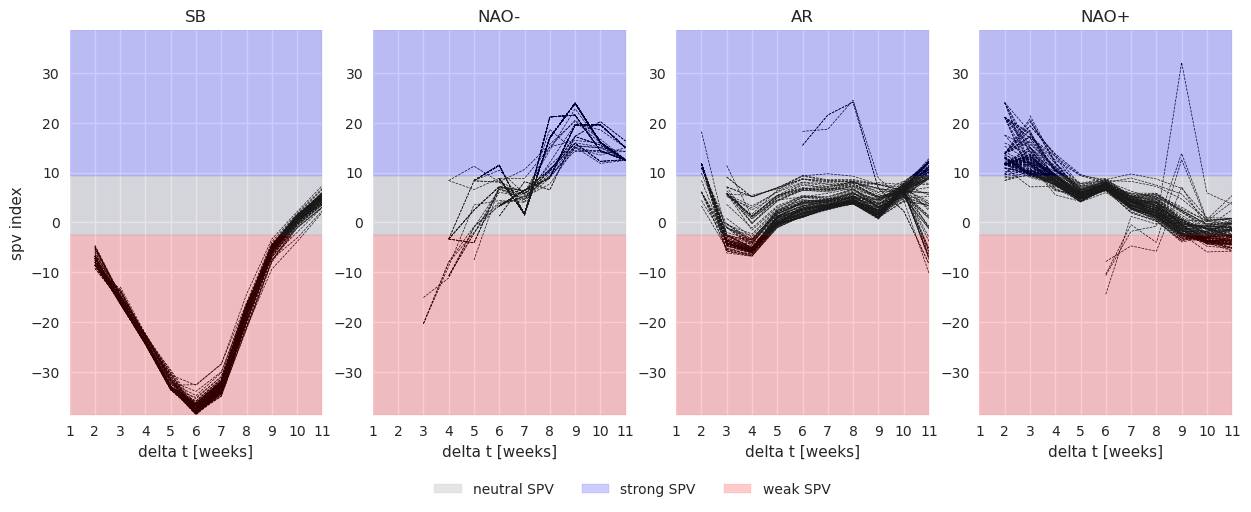

In [35]:
fig, axes = plt.subplots(1, len(regimes), figsize=(15,5))#, sharex = True)
delta_t = np.arange(1,np.max(np.unique(np.array(delta_t_pv[regimes[0]]['delta t'])))+1)
mult_dt = np.repeat(delta_t[None,:],pv_anom_reg_dt.shape[0], axis= 0)

med_perc = np.nanpercentile(pv_anom_reg_dt[:,:,:].flatten(),30) # upper thresh weak (Tripathi et al. 2015)
strong_perc = np.nanpercentile(pv_anom_reg_dt[:,:,:].flatten(),80) # lower thresh strong (Tripathi et al. 2015)

vmax = np.nanmax(np.abs(pv_anom_reg_dt[:,:,:].flatten()))

for i, (keys, plot_val_pv) in enumerate(delta_t_pv.items()):
    ax = axes[i]

    plot_data_pv = pv_anom_reg_dt[:,i,:]
    weak_pv = []
    med_pv = []
    strong_pv = []
    for i in range(plot_data_pv.shape[0]):

        ax.plot(mult_dt[i,:],plot_data_pv[i,:], color='black', 
                linestyle='dashed', linewidth=0.5, zorder=1)


    ax.fill_between(delta_t, med_perc, strong_perc, color='grey', alpha=0.2, label = 'neutral SPV')
    ax.fill_between(delta_t, strong_perc, vmax, color='blue', alpha=0.2, label = 'strong SPV')
    ax.fill_between(delta_t, -vmax, med_perc, color='red', alpha=0.2, label = 'weak SPV')
    

    ax.set_ylim(-vmax,vmax)
    ax.set_xlim(delta_t[0], delta_t[-1])
    ax.set_xticks(delta_t)
    ax.set_title(f'{keys}')

    ax.set_xlabel(f'delta t [weeks]')
   

axes[0].set_ylabel(f'spv index')
handles, labels = ax.get_legend_handles_labels()
# fig.legend(handles, labels, loc='lower center', ncol=2)
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=3)
fig.savefig(f"{results_directory}/{arch_type}_deltaT_90th_percentile_spvIndex_line_areas.png", dpi=600, bbox_inches='tight')

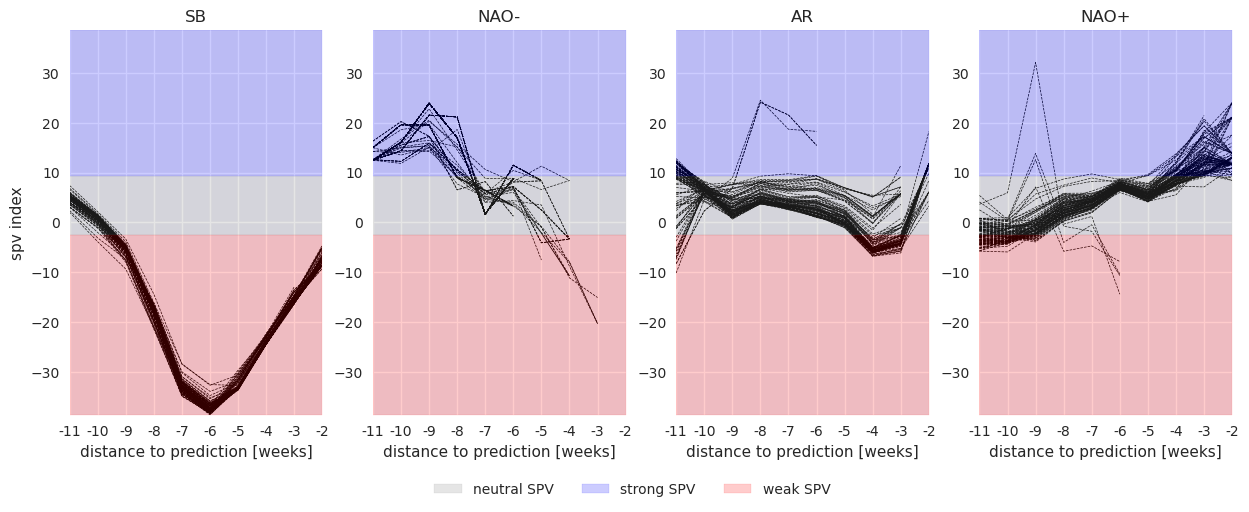

In [36]:
fig, axes = plt.subplots(1, len(regimes), figsize=(15,5))#, sharex = True)
mult_dt = np.repeat(delta_t[None,:],pv_anom_reg_dt.shape[0], axis= 0)

med_perc = np.nanpercentile(pv_anom_reg_dt[:,:,:].flatten(),30) # upper thresh weak (Tripathi et al. 2015)
strong_perc = np.nanpercentile(pv_anom_reg_dt[:,:,:].flatten(),80) # lower thresh strong (Tripathi et al. 2015)

vmax = np.nanmax(np.abs(pv_anom_reg_dt[:,:,:].flatten()))
delta_t = np.unique(np.array(delta_t_pv[regimes[0]]['delta t']))

for i, (keys, plot_val_pv) in enumerate(delta_t_pv.items()):
    ax = axes[i]

    plot_data_pv = pv_anom_reg_dt[:,i,:]
    weak_pv = []
    med_pv = []
    strong_pv = []
    for i in range(plot_data_pv.shape[0]):

        
        ax.plot(np.flip(mult_dt[i,:]),np.flip(plot_data_pv[i,:]), color='black', 
                linestyle='dashed', linewidth=0.5, zorder=1)


    ax.fill_between(np.flip(delta_t), med_perc, strong_perc, color='grey', alpha=0.2, label = 'neutral SPV')
    ax.fill_between(np.flip(delta_t), strong_perc, vmax, color='blue', alpha=0.2, label = 'strong SPV')
    ax.fill_between(np.flip(delta_t), -vmax, med_perc, color='red', alpha=0.2, label = 'weak SPV')
    

    ax.set_ylim(-vmax,vmax)
    ax.set_xlim(np.flip(delta_t)[0], np.flip(delta_t)[-1])
    ax.set_xticks(np.flip(delta_t))
    ax.set_xticklabels(-np.flip(delta_t))
    ax.set_title(f'{keys}')

    ax.set_xlabel(f'distance to prediction [weeks]')
   

axes[0].set_ylabel(f'spv index')
handles, labels = ax.get_legend_handles_labels()
# fig.legend(handles, labels, loc='lower center', ncol=2)
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=3)
fig.savefig(f"{results_directory}/{arch_type}_deltaT_90th_percentile_spvIndex_line_areas_flipped.png", dpi=600, bbox_inches='tight')

## Violin Plots

In [37]:
sum_spv_reg = np.zeros((4,1))
cnts_reg_in  = np.zeros((4,1))


for i in range(loop_probabilities.shape[0]):
    for j in range(loop_probabilities.shape[1]):
        for k in range(loop_probabilities.shape[2]):
            for t in range(pv_inputs.shape[2]):
                if not np.isnan(pv_inputs[i,j,t]):
                    cnts_reg_in[input_reg[j,k]] += 1
                    sum_spv_reg[input_reg[j,k]] += pv_inputs[i,j,t]

avg_spv = (sum_spv_reg.T/cnts_reg_in).flatten()


pv_anomalies = np.zeros(pv_inputs.shape)

for i in range(loop_probabilities.shape[0]):
    for j in range(loop_probabilities.shape[1]):
        for k in range(loop_probabilities.shape[2]):
            for t in range(pv_inputs.shape[2]):
                    if not np.isnan(pv_inputs[i,j,t]):
                        pv_anomalies[i,j,t] = pv_inputs[i,j,t]- avg_spv[input_reg[j,k]]

t_in, t_out = pv_inputs.shape[2],loop_probabilities.shape[2]

pv_anom_reg = []
pv_inp_reg = []

for i in range(loop_probabilities.shape[0]): # number models
    pv_reg_dt = np.zeros((4,t_in +t_out-1))
    pv_inp_dt = np.zeros((4,t_in +t_out-1))
    cnt_correct_dt = np.zeros((4,t_in +t_out-1))
    for j in range(loop_probabilities.shape[1]): # number weeks/ samples
        for r, reg in enumerate(regimes): # classes
            for k in range(loop_probabilities.shape[2]): # output timesteps
                for t in range(pv_inputs.shape[2]): #input timesteps
                    if not np.isnan(pv_inputs[i,j,t]):
                        if r == loop_classes[i,j,t]:
                            if loop_probabilities[i,j,k,r] > qall_90:
                                d_t = np.abs((t-5)) + (k+1)
                                cnt_correct_dt[loop_targets[i,j,k], d_t-1] += 1
                                pv_reg_dt[loop_targets[i,j,k], d_t-1] += pv_anomalies[i,j,t]
                                pv_inp_dt[loop_targets[i,j,k], d_t-1] += pv_inputs[i,j,t] #- avg_spv[loop_targets[i,j,k]]
    pv_anom_reg.append(pv_reg_dt[None,:,:]/cnt_correct_dt[None,:,:])
    pv_inp_reg.append(pv_inp_dt[None,:,:]/cnt_correct_dt[None,:,:])

pv_anom_reg = np.concatenate(pv_anom_reg)
pv_inp_reg = np.concatenate(pv_inp_reg)

/tmp/ipykernel_66863/3012553172.py:45: RuntimeWarning: invalid value encountered in divide
  pv_anom_reg.append(pv_reg_dt[None,:,:]/cnt_correct_dt[None,:,:])
/tmp/ipykernel_66863/3012553172.py:46: RuntimeWarning: invalid value encountered in divide
  pv_inp_reg.append(pv_inp_dt[None,:,:]/cnt_correct_dt[None,:,:])


## Shifted initialization by output prediction

/mnt/beegfs/home/bommer1/.conda/envs/STNN/lib/python3.10/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


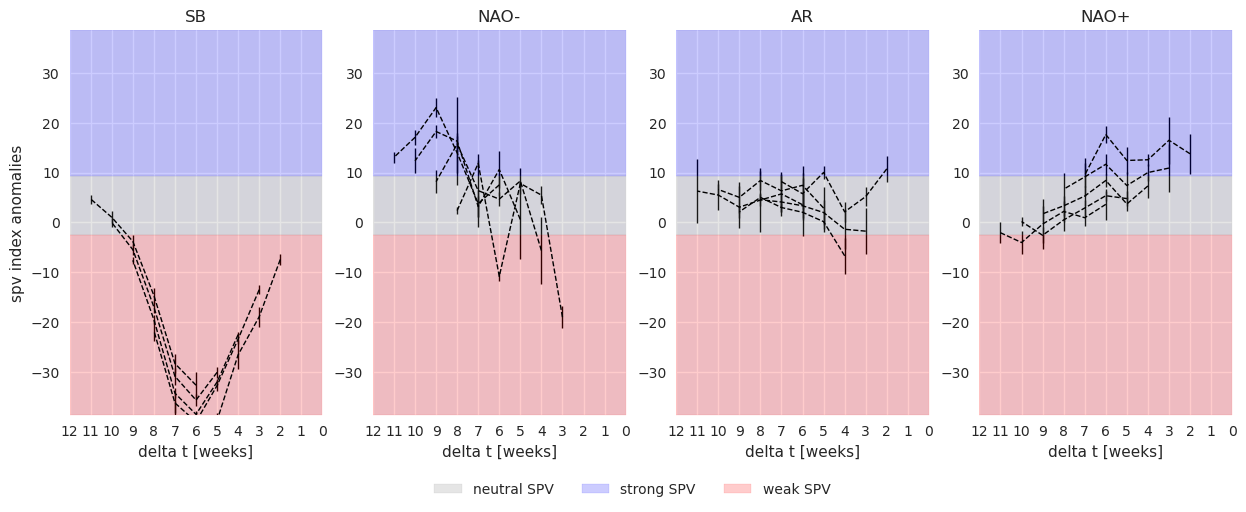

In [38]:
fig, axes = plt.subplots(1, len(regimes), figsize=(15,5))#, sharex = True)
mult_dt = np.repeat(delta_t[None,:],pv_anom_reg_dt.shape[0], axis= 0)

med_perc = np.nanpercentile(pv_anom_reg_dt[:,:,:].flatten(),30) # upper thresh weak (Tripathi et al. 2015)
strong_perc = np.nanpercentile(pv_anom_reg_dt[:,:,:].flatten(),80) # lower thresh strong (Tripathi et al. 2015)

vmax = np.nanmax(np.abs(pv_anom_reg_dt[:,:,:].flatten()))
delta_t = np.unique(np.array(delta_t_pv[regimes[0]]['delta t']))
delta_t = np.arange(0,delta_t[-1]+2)

for i, (keys, plot_val_pv) in enumerate(delta_t_pv.items()):
    ax = axes[i]

    plot_data_pv = pv_anom_reg_mean[i]
    plot_uncert_pv = pv_anom_reg_std[i]
    for t in range(plot_data_pv.shape[0]):
        dt = np.flip(np.arange(len(plot_data_pv[t,:]))+t+1)

        ax.errorbar(np.flip(dt), np.flip(plot_data_pv[t,:]), yerr=np.flip(plot_uncert_pv[t,:]), color='black', 
                linestyle='dashed', linewidth=1, zorder=1)



    ax.fill_between(np.flip(delta_t), med_perc, strong_perc, color='grey', alpha=0.2, label = 'neutral SPV')
    ax.fill_between(np.flip(delta_t), strong_perc, vmax, color='blue', alpha=0.2, label = 'strong SPV')
    ax.fill_between(np.flip(delta_t), -vmax, med_perc, color='red', alpha=0.2, label = 'weak SPV')
    

    ax.set_ylim(-vmax,vmax)
    ax.set_xlim(np.flip(delta_t)[0], np.flip(delta_t)[-1])
    ax.set_xticks(np.flip(delta_t))
    ax.set_xticklabels(np.flip(delta_t))
    ax.set_title(f'{keys}')

    ax.set_xlabel(f'delta t [weeks]')
   

axes[0].set_ylabel(f'spv index anomalies')
handles, labels = ax.get_legend_handles_labels()
# fig.legend(handles, labels, loc='lower center', ncol=2)
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=3)
fig.savefig(f"{results_directory}/{arch_type}_deltaT_90th_percentile_spvIndex_shifted_dt.png", dpi=600, bbox_inches='tight')

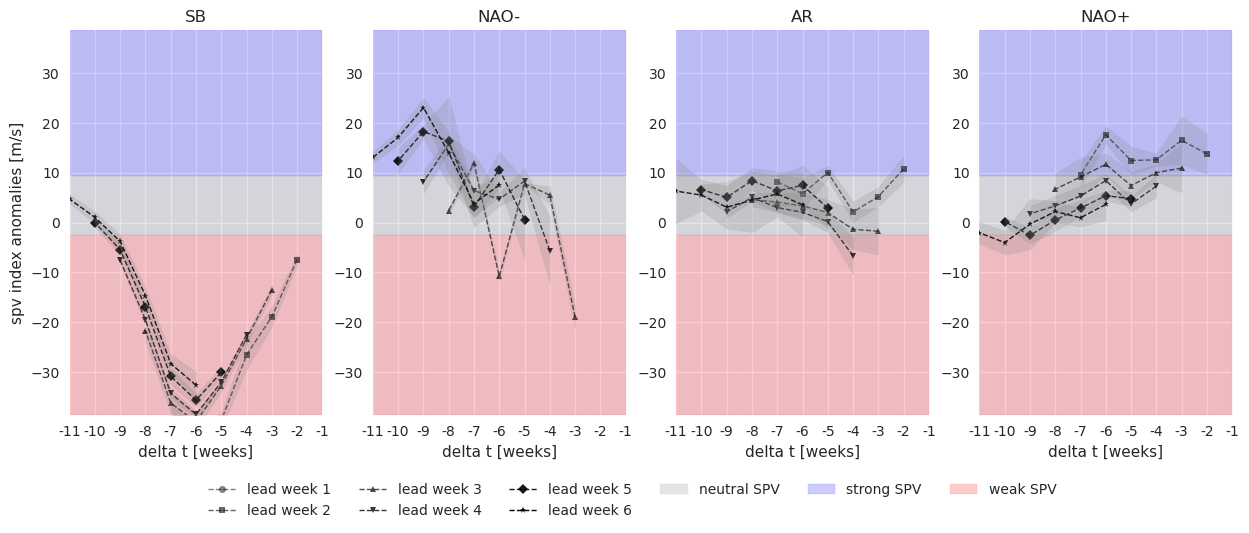

In [39]:
fig, axes = plt.subplots(1, len(regimes), figsize=(15,5))#, sharex = True)
mult_dt = np.repeat(delta_t[None,:],pv_anom_reg_dt.shape[0], axis= 0)

med_perc = np.nanpercentile(pv_anom_reg_dt[:,:,:].flatten(),30) # upper thresh weak (Tripathi et al. 2015)
strong_perc = np.nanpercentile(pv_anom_reg_dt[:,:,:].flatten(),80) # lower thresh strong (Tripathi et al. 2015)

vmax = np.nanmax(np.abs(pv_anom_reg_dt[:,:,:].flatten()))
delta_t = np.unique(np.array(delta_t_pv[regimes[0]]['delta t']))
delta_t = np.arange(1,delta_t[-1]+1)
alphas = np.linspace(0.5,1, 6)
marker_list = ['o','s','^','v','D','*']

for i, (keys, plot_val_pv) in enumerate(delta_t_pv.items()):
    ax = axes[i]

    plot_data_pv = pv_anom_reg_mean[i]
    plot_uncert_pv = pv_anom_reg_std[i]
    for t in range(plot_data_pv.shape[0]):
        dt = np.flip(np.arange(len(plot_data_pv[t,:]))+t+1)

        ax.plot(np.flip(dt), np.flip(plot_data_pv[t,:]), color='black', marker = marker_list[t], markersize = 5, alpha = alphas[t],
                linestyle='dashed', linewidth=1, zorder=2, label = f'lead week {t+1}')
        ax.fill_between(np.flip(dt), np.flip(plot_data_pv[t,:]) - np.flip(plot_uncert_pv[t,:]), 
                np.flip(plot_data_pv[t,:]) + np.flip(plot_uncert_pv[t,:]), color='grey', alpha=0.2, zorder=2)



    # ax.axhline(med_perc, color='red', label = 'weak SPV')
    # ax.axhline(strong_perc, color='blue',label = 'strong SPV')
    ax.fill_between(np.flip(delta_t), med_perc, strong_perc, color='grey', alpha=0.2, label = 'neutral SPV', zorder=1)
    ax.fill_between(np.flip(delta_t), strong_perc, vmax, color='blue', alpha=0.2, label = 'strong SPV', zorder=1)
    ax.fill_between(np.flip(delta_t), -vmax, med_perc, color='red', alpha=0.2, label = 'weak SPV', zorder=1)
    

    ax.set_ylim(-vmax,vmax)
    ax.set_xlim(np.flip(delta_t)[0], np.flip(delta_t)[-1])
    ax.set_xticks(np.flip(delta_t))
    ax.set_xticklabels(-np.flip(delta_t))
    ax.set_title(f'{keys}')

    ax.set_xlabel(f'delta t [weeks]')
   

axes[0].set_ylabel(f'spv index anomalies [m/s]')
handles, labels = ax.get_legend_handles_labels()
# fig.legend(handles, labels, loc='lower center', ncol=2)
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=6)
fig.savefig(f"{results_directory}/{arch_type}_deltaT_90th_percentile_spvIndex_shifted_dt.png", dpi=600, bbox_inches='tight')              

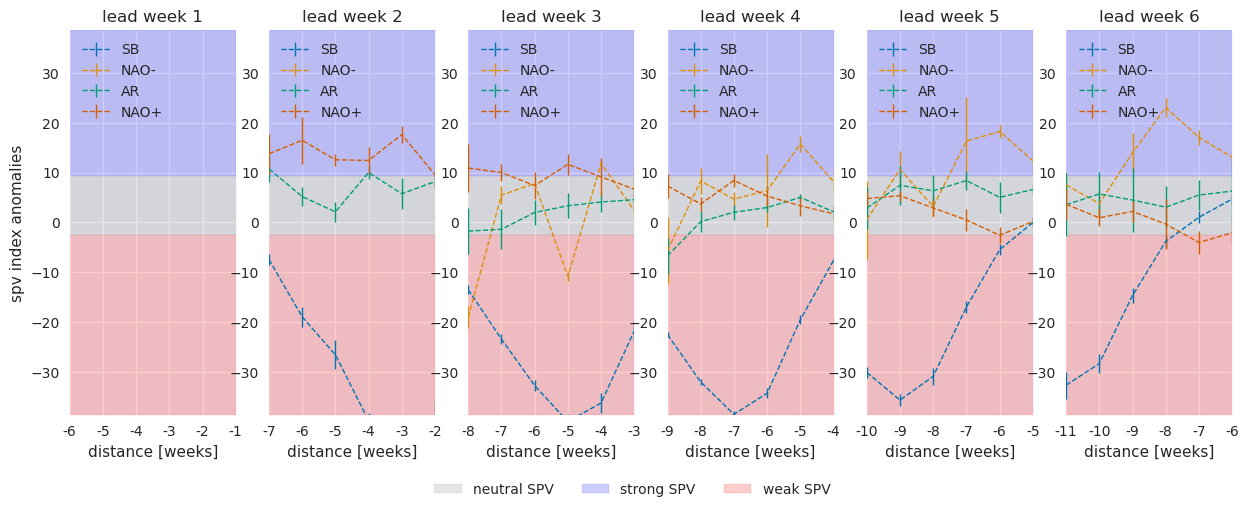

In [40]:
fig, axes = plt.subplots(1, pv_anom_reg_mean.shape[1], figsize=(15,5))#, sharex = True)
mult_dt = np.repeat(delta_t[None,:],pv_anom_reg_dt.shape[0], axis= 0)

med_perc = np.nanpercentile(pv_anom_reg_dt[:,:,:].flatten(),30) # upper thresh weak (Tripathi et al. 2015)
strong_perc = np.nanpercentile(pv_anom_reg_dt[:,:,:].flatten(),80) # lower thresh strong (Tripathi et al. 2015)

vmax = np.nanmax(np.abs(pv_anom_reg_dt[:,:,:].flatten()))
colors = sns.color_palette("colorblind", n_colors=4)
for t in range(pv_anom_reg_mean.shape[1]):

    ax = axes[t]

    for i, (keys, plot_val_pv) in enumerate(delta_t_pv.items()):

        plot_data_pv = pv_anom_reg_mean[i, t, :]
        plot_uncert_pv = pv_anom_reg_std[i, t, :]

        dt = np.flip(np.arange(len(plot_data_pv))+1)

        ax.errorbar(np.flip(dt), np.flip(plot_data_pv), yerr=np.flip(plot_uncert_pv), color=colors[i], 
                linestyle='dashed', linewidth=1, label = f'{keys}')
            
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='upper left')


    neutral = ax.fill_between(np.flip(dt), med_perc, strong_perc, color='grey', alpha=0.2, label = 'neutral SPV')
    strong = ax.fill_between(np.flip(dt), strong_perc, vmax, color='blue', alpha=0.2, label = 'strong SPV')
    weak = ax.fill_between(np.flip(dt), -vmax, med_perc, color='red', alpha=0.2, label = 'weak SPV')
    

    ax.set_ylim(-vmax,vmax)
    ax.set_xlim(np.flip(dt)[0], np.flip(dt)[-1])
    ax.set_xticks(np.flip(dt))
    dt = np.arange(len(plot_data_pv))+t+1
    ax.set_xticklabels(-np.flip(dt))
    ax.set_title(f'lead week {t+1}')

    ax.set_xlabel(f'distance [weeks]')
   

axes[0].set_ylabel(f'spv index anomalies')
# handles, labels = ax.get_legend_handles_labels()
# fig.legend(handles, labels, loc='lower center', ncol=2)
fig.legend([neutral,strong, weak], ['neutral SPV','strong SPV','weak SPV'], loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=3)
# fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=3)
fig.savefig(f"{results_directory}/{arch_type}_deltaT_90th_percentile_spvIndex_per_output.png", dpi=600, bbox_inches='tight')

## Shifted according to targets

In [41]:
pv_anom_tar_t = []
pv_inp_tar_t = []
pv_anom_tar_dt = []
dt_dict = {t: [] for t in range(t_in +t_out-1)}
pv_anom_tar = {r: dt_dict for r in range(len(regimes))}

for i in range(loop_probabilities.shape[0]): # number models
    pv_tar_t = np.zeros((4,t_in, t_out))
    pv_tar_t_in = np.zeros((4,t_in, t_out))
    cnt_correct_tar = np.zeros((4,t_in, t_out))
    pv_tar_dt = np.zeros((4,t_in +t_out-1))
    cnt_tar_dt = np.zeros((4,t_in +t_out-1))
    for j in range(loop_probabilities.shape[1]): # number weeks/ samples
        for k in range(loop_probabilities.shape[2]): # output timesteps
            for t in range(pv_inputs.shape[2]): #input timesteps
                if not np.isnan(pv_inputs[i,j,t]):
                    cnt_correct_tar[loop_targets[i,j,k], k, t] += 1
                    pv_tar_t[loop_targets[i,j,k], k, t] += pv_anomalies[i,j,t]
                    pv_tar_t_in[loop_targets[i,j,k], k, t] += pv_inputs[i,j,t] #- avg_spv[loop_targets[i,j,k]]

                    d_t = np.abs((t-5)) + (k+1)
                    cnt_tar_dt[loop_targets[i,j,k], d_t-1] += 1
                    pv_anom_tar[loop_targets[i,j,k]][d_t-1].append(pv_anomalies[i,j,t])
                    pv_tar_dt[loop_targets[i,j,k], d_t-1] += pv_anomalies[i,j,t]

    pv_anom_tar_t.append(pv_tar_t[None,...]/cnt_correct_tar[None,...])
    pv_inp_tar_t.append(pv_tar_t_in[None,...]/cnt_correct_tar[None,...])
    pv_anom_tar_dt.append(pv_tar_dt[None,...]/cnt_tar_dt[None,...])

pv_anom_tar_t = np.concatenate(pv_anom_tar_t) # num models x num classes x num output timesteps x num input timesteps
pv_inp_tar_t = np.concatenate(pv_inp_tar_t)
pv_anom_tar_dt = np.concatenate(pv_anom_tar_dt)

pv_anom_tar_mean = np.nanmean(pv_anom_tar_t, axis = 0)
pv_anom_tar_std = np.nanstd(pv_anom_tar_t, axis = 0)
pv_anom_tar_dt_mean = np.nanmean(pv_anom_tar_dt, axis = 0)
pv_anom_tar_dt_std = np.nanstd(pv_anom_tar_dt, axis = 0)

In [42]:
pv_tar_dt_anom_mean = np.zeros((4,6,t_in +t_out-1))
pv_tar_dt_anom_mean[:] = np.nan
pv_tar_dt_anom_std = np.zeros((4,6,t_in +t_out-1))
pv_tar_dt_anom_std[:] = np.nan
for reg in range(pv_anom_tar_mean.shape[0]):
    for t in range(pv_anom_tar_mean.shape[1]):
        dts = np.arange(len(pv_anom_tar_mean[reg,t,:]))+t
        pv_tar_dt_anom_mean[reg,t,dts] = pv_anom_tar_mean[reg,t,:]
        pv_tar_dt_anom_std[reg,t,dts] = pv_anom_tar_std[reg,t,:]

pv_all_dt_anom_means = np.nanmean(pv_tar_dt_anom_mean, axis = 1)
pv_all_dt_anom_stds = np.nanstd(pv_tar_dt_anom_mean, axis = 1) + np.nanmean(pv_tar_dt_anom_std, axis = 1) #error propagation


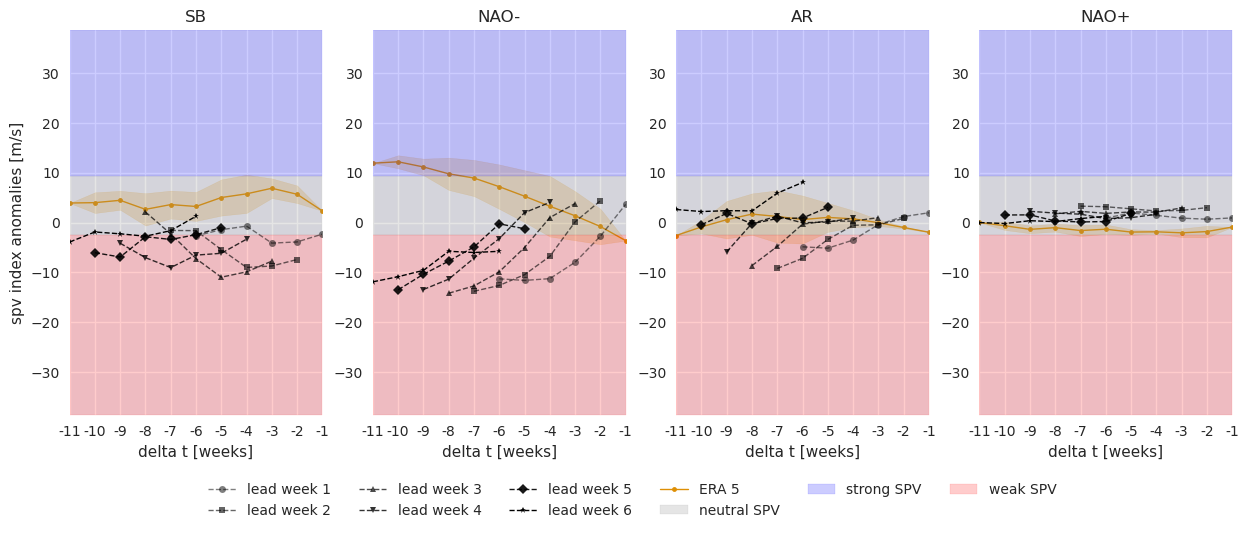

In [43]:
fig, axes = plt.subplots(1, len(regimes), figsize=(15,5))#, sharex = True)
mult_dt = np.repeat(delta_t[None,:],pv_anom_reg_dt.shape[0], axis= 0)

med_perc = np.nanpercentile(pv_anom_reg_dt[:,:,:].flatten(),30) # upper thresh weak (Tripathi et al. 2015)
strong_perc = np.nanpercentile(pv_anom_reg_dt[:,:,:].flatten(),80) # lower thresh strong (Tripathi et al. 2015)

vmax = np.nanmax(np.abs(pv_anom_reg_dt[:,:,:].flatten()))
delta_t = np.unique(np.array(delta_t_pv[regimes[0]]['delta t']))
delta_t = np.arange(1,delta_t[-1]+1)
alphas = np.linspace(0.5,1, 6)
marker_list = ['o','s','^','v','D','*']

for i, (keys, plot_val_pv) in enumerate(delta_t_pv.items()):
    ax = axes[i]

    plot_data_pv = pv_anom_tar_mean[i]
    plot_uncert_pv = pv_anom_tar_std[i]
    for t in range(plot_data_pv.shape[0]):
        dt = np.flip(np.arange(len(plot_data_pv[t,:]))+t+1)

        ax.plot(dt, np.flip(plot_data_pv[t,:]), color='black', marker = marker_list[t], markersize = 5, alpha = alphas[t],
                linestyle='dashed', linewidth=1, zorder=2, label = f'lead week {t+1}')
        # ax.fill_between(np.flip(dt), np.flip(plot_data_pv[t,:]) - np.flip(plot_uncert_pv[t,:]), 
        #         np.flip(plot_data_pv[t,:]) + np.flip(plot_uncert_pv[t,:]), color='grey', alpha=0.2, zorder=2)


    ax.plot(np.flip(delta_t),np.flip(-pv_all_dt_anom_means[i,:]), color=cm_list[1], linewidth=1, marker = '.', markersize = 7, zorder=1, label = 'ERA 5')
    ax.fill_between(np.flip(delta_t), np.flip(- pv_all_dt_anom_means[i,:]) - np.flip(pv_all_dt_anom_stds[i,:]),
                    np.flip(-pv_all_dt_anom_means[i,:]) + np.flip(pv_all_dt_anom_stds[i,:]), color=cm_list[1], alpha=0.2, zorder=1)
    
    # ax.axhline(med_perc, color='red', label = 'weak SPV')
    # ax.axhline(strong_perc, color='blue',label = 'strong SPV')
    ax.fill_between(np.flip(delta_t), med_perc, strong_perc, color='grey', alpha=0.2, label = 'neutral SPV', zorder=1)
    ax.fill_between(np.flip(delta_t), strong_perc, vmax, color='blue', alpha=0.2, label = 'strong SPV', zorder=1)
    ax.fill_between(np.flip(delta_t), -vmax, med_perc, color='red', alpha=0.2, label = 'weak SPV', zorder=1)
    

    ax.set_ylim(-vmax,vmax)
    ax.set_xlim(np.flip(delta_t)[0], np.flip(delta_t)[-1])
    ax.set_xticks(np.flip(delta_t))
    ax.set_xticklabels(-np.flip(delta_t))
    ax.set_title(f'{keys}')

    ax.set_xlabel(f'delta t [weeks]')
   

axes[0].set_ylabel(f'spv index anomalies [m/s]')
handles, labels = ax.get_legend_handles_labels()
# fig.legend(handles, labels, loc='lower center', ncol=2)
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=6)
fig.savefig(f"{results_directory}/{arch_type}_deltaT_targets_spvIndex_shifted_dt.png", dpi=600, bbox_inches='tight')              

## Shifted relative to all predictions

In [44]:
pv_anom_all_t = []
pv_inp_all_t = []
pv_anom_all_dt = []

for i in range(loop_probabilities.shape[0]): # number models
    pv_all_t = np.zeros((4,t_in, t_out))
    pv_all_in_t = np.zeros((4,t_in, t_out))
    cnt_correct_all = np.zeros((4,t_in, t_out))
    pv_all_dt = np.zeros((4,t_in +t_out-1))
    cnt_all_dt = np.zeros((4,t_in +t_out-1))
    for j in range(loop_probabilities.shape[1]): # number weeks/ samples
        for k in range(loop_probabilities.shape[2]): # output timesteps
            for t in range(pv_inputs.shape[2]): #input timesteps
                if not np.isnan(pv_inputs[i,j,t]):
                    cnt_correct_all[loop_classes[i,j,k], k, t] += 1
                    pv_all_t[loop_classes[i,j,k], k, t] += pv_anomalies[i,j,t]
                    pv_all_in_t[loop_classes[i,j,k], k, t] += pv_inputs[i,j,t] #- avg_spv[loop_targets[i,j,k]]

                    d_t = np.abs((t-5)) + (k+1)
                    cnt_all_dt[loop_classes[i,j,k], d_t-1] += 1
                    pv_all_dt[loop_classes[i,j,k], d_t-1] += pv_anomalies[i,j,t]
    pv_anom_all_t.append(pv_all_t[None,...]/cnt_correct_all[None,...])
    pv_inp_all_t.append(pv_all_in_t[None,...]/cnt_correct_all[None,...])
    pv_anom_all_dt.append(pv_all_dt[None,...]/cnt_all_dt[None,...])

pv_anom_all_t = np.concatenate(pv_anom_all_t) # num models x num classes x num output timesteps x num input timesteps
pv_inp_all_t = np.concatenate(pv_inp_all_t)

pv_anom_all_mean = np.nanmean(pv_anom_all_t, axis = 0)
pv_anom_all_std = np.nanstd(pv_anom_all_t, axis = 0)

pv_anom_all_dt = np.concatenate(pv_anom_all_dt)
pv_anom_all_dt_mean = np.nanmean(pv_anom_all_dt, axis = 0)
pv_anom_all_dt_std = np.nanstd(pv_anom_all_dt, axis = 0)


/tmp/ipykernel_66863/237725771.py:22: RuntimeWarning: invalid value encountered in divide
  pv_anom_all_t.append(pv_all_t[None,...]/cnt_correct_all[None,...])
/tmp/ipykernel_66863/237725771.py:23: RuntimeWarning: invalid value encountered in divide
  pv_inp_all_t.append(pv_all_in_t[None,...]/cnt_correct_all[None,...])
/tmp/ipykernel_66863/237725771.py:24: RuntimeWarning: invalid value encountered in divide
  pv_anom_all_dt.append(pv_all_dt[None,...]/cnt_all_dt[None,...])


In [45]:
pv_all_dt_anom_mean = np.zeros((4,6,t_in +t_out-1))
pv_all_dt_anom_mean[:] = np.nan
pv_all_dt_anom_std = np.zeros((4,6,t_in +t_out-1))
pv_all_dt_anom_std[:] = np.nan
for reg in range(pv_anom_all_mean.shape[0]):
    for t in range(pv_anom_all_mean.shape[1]):
        dts = np.arange(len(pv_anom_all_mean[reg,t,:]))+t
        pv_all_dt_anom_mean[reg,t,dts] = pv_anom_all_mean[reg,t,:]
        pv_all_dt_anom_std[reg,t,dts] = pv_anom_all_std[reg,t,:]

pv_all_dt_anom_means = np.nanmean(pv_all_dt_anom_mean, axis = 1)
pv_all_dt_anom_stds = np.nanstd(pv_all_dt_anom_mean, axis = 1) + np.nanmean(pv_all_dt_anom_std, axis = 1) #error propagation


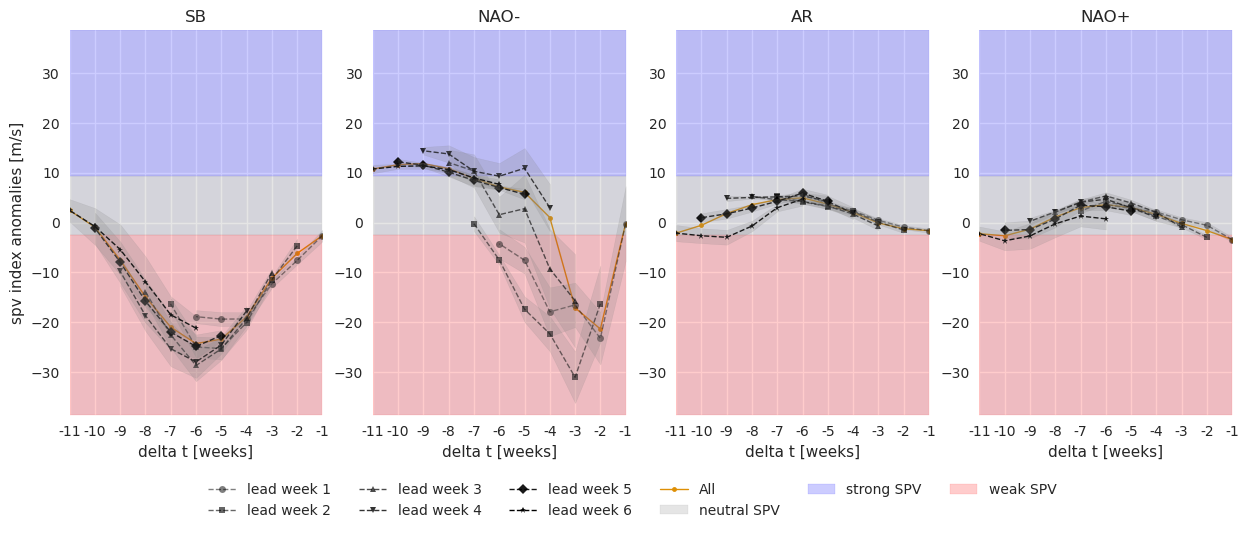

In [46]:
fig, axes = plt.subplots(1, len(regimes), figsize=(15,5))#, sharex = True)
mult_dt = np.repeat(delta_t[None,:],pv_anom_reg_dt.shape[0], axis= 0)

med_perc = np.nanpercentile(pv_anom_reg_dt[:,:,:].flatten(),30) # upper thresh weak (Tripathi et al. 2015)
strong_perc = np.nanpercentile(pv_anom_reg_dt[:,:,:].flatten(),80) # lower thresh strong (Tripathi et al. 2015)

vmax = np.nanmax(np.abs(pv_anom_reg_dt[:,:,:].flatten()))
delta_t = np.unique(np.array(delta_t_pv[regimes[0]]['delta t']))
delta_t = np.arange(1,delta_t[-1]+1)
alphas = np.linspace(0.5,1, 6)
marker_list = ['o','s','^','v','D','*']

for i, (keys, plot_val_pv) in enumerate(delta_t_pv.items()):
    ax = axes[i]

    plot_data_pv = pv_anom_all_mean[i]
    plot_uncert_pv = pv_anom_all_std[i]
    for t in range(plot_data_pv.shape[0]):
        dt = np.flip(np.arange(len(plot_data_pv[t,:]))+t+1)

        ax.plot(np.flip(dt), np.flip(plot_data_pv[t,:]), color='black', marker = marker_list[t], markersize = 5, alpha = alphas[t],
                linestyle='dashed', linewidth=1, zorder=2, label = f'lead week {t+1}')
        ax.fill_between(np.flip(dt), np.flip(plot_data_pv[t,:]) - np.flip(plot_uncert_pv[t,:]), 
                np.flip(plot_data_pv[t,:]) + np.flip(plot_uncert_pv[t,:]), color='grey', alpha=0.2, zorder=2)

    
    ax.plot(np.flip(delta_t),np.flip(pv_anom_all_dt_mean[i,:]), color=cm_list[1], linewidth=1, marker = '.', markersize = 7, zorder=1, label = 'All')

    # ax.axhline(med_perc, color='red', label = 'weak SPV')
    # ax.axhline(strong_perc, color='blue',label = 'strong SPV')
    ax.fill_between(np.flip(delta_t), med_perc, strong_perc, color='grey', alpha=0.2, label = 'neutral SPV', zorder=1)
    ax.fill_between(np.flip(delta_t), strong_perc, vmax, color='blue', alpha=0.2, label = 'strong SPV', zorder=1)
    ax.fill_between(np.flip(delta_t), -vmax, med_perc, color='red', alpha=0.2, label = 'weak SPV', zorder=1)
    

    ax.set_ylim(-vmax,vmax)
    ax.set_xlim(np.flip(delta_t)[0], np.flip(delta_t)[-1])
    ax.set_xticks(np.flip(delta_t))
    ax.set_xticklabels(-np.flip(delta_t))
    ax.set_title(f'{keys}')

    ax.set_xlabel(f'delta t [weeks]')
   

axes[0].set_ylabel(f'spv index anomalies [m/s]')
handles, labels = ax.get_legend_handles_labels()
# fig.legend(handles, labels, loc='lower center', ncol=2)
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=6)
fig.savefig(f"{results_directory}/{arch_type}_deltaT_all_spvIndex_shifted_dt.png", dpi=600, bbox_inches='tight')              


## Analysis plot A

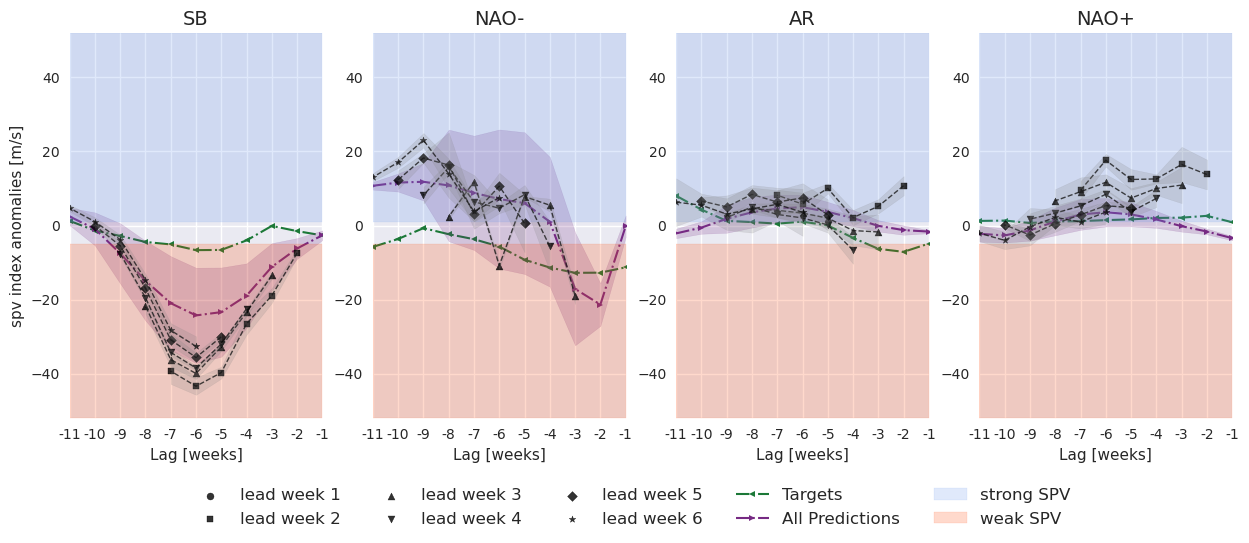

In [47]:
#add mean targets and all predictions
cm_list = ['#7fbf7b','#1b7837','#762a83','#9970ab','#c2a5cf'] 
fig, axes = plt.subplots(1, len(regimes), figsize=(15,5))#, sharex = True)
mult_dt = np.repeat(delta_t[None,:],pv_anom_reg_dt.shape[0], axis= 0)

med_perc = np.nanpercentile(pv_anom_tar_dt[:,:,0].flatten(),30) # upper thresh weak (Tripathi et al. 2015)
strong_perc = np.nanpercentile(pv_anom_tar_dt[:,:,0].flatten(),80) # lower thresh strong (Tripathi et al. 2015)

# vmax = np.nanmax(np.abs(pv_anom_reg_mean.flatten()))
vmax = 52
delta_t = np.unique(np.array(delta_t_pv[regimes[0]]['delta t']))
delta_t = np.arange(1,delta_t[-1]+1)
colors = sns.color_palette("colorblind", n_colors=6)
alphas = np.linspace(0.5,1, 6)
marker_list = ['o','s','^','v','D','*']

for i, (keys, plot_val_pv) in enumerate(delta_t_pv.items()):
    ax = axes[i]

    plot_data_pv = pv_anom_reg_mean[i]
    plot_uncert_pv = pv_anom_reg_std[i]
    for t in range(plot_data_pv.shape[0]):
        dt = np.flip(np.arange(len(plot_data_pv[t,:]))+t+1)

        ax.scatter(np.flip(dt), np.flip(plot_data_pv[t,:]), color='black', marker = marker_list[t], s = 25, alpha = 0.8,
                    zorder=2, label = f'lead week {t+1}')

        ax.plot(np.flip(dt), np.flip(plot_data_pv[t,:]), color='black', alpha = 0.8,#alphas[t],
                linestyle='dashed', linewidth=1, zorder=2, )#label = f'lead week {t+1}')
        ax.fill_between(np.flip(dt), np.flip(plot_data_pv[t,:]) - np.flip(plot_uncert_pv[t,:]), 
                np.flip(plot_data_pv[t,:]) + np.flip(plot_uncert_pv[t,:]), color='grey', alpha=0.2, zorder=2)


    ax.plot(np.flip(delta_t),np.flip(pv_anom_tar_dt_mean[i,:]), color=cm_list[1], linewidth=1.5, marker = '<', linestyle = '-.',
            markersize = 5, zorder=1, label = 'Targets') #label = 'ERA 5'
    ax.plot(np.flip(delta_t),np.flip(pv_anom_all_dt_mean[i,:]), color=cm_list[2], linewidth=1.5, marker = '>', linestyle = '-.',
            markersize = 5, zorder=1, label = 'All Predictions') #label = 'All'
    ax.fill_between(np.flip(delta_t), np.flip(pv_anom_all_dt_mean[i,:]) - np.flip(pv_all_dt_anom_stds[i,:]),
                    np.flip(pv_anom_all_dt_mean[i,:]) + np.flip(pv_all_dt_anom_stds[i,:]), color=cm_list[2],alpha=0.2, zorder=1)
    # ax.fill_between(np.flip(delta_t), np.flip(pv_anom_tar_dt_mean[i,:]) - np.flip(pv_all_dt_anom_stds[i,:]),
    #                 np.flip(pv_anom_tar_dt_mean[i,:]) + np.flip(pv_all_dt_anom_stds[i,:]), color=cm_list[1], alpha=0.2, zorder=1)
    # pv_anom_tar_dt_std
    # ax.axhline(med_perc, color='red', label = 'weak SPV')
    # ax.axhline(strong_perc, color='blue',label = 'strong SPV')
    # ax.fill_between(np.flip(delta_t), med_perc, strong_perc, color='grey', alpha=0.2, label = 'neutral SPV', zorder=1)
    ax.fill_between(np.flip(delta_t), strong_perc, vmax, color='cornflowerblue', alpha=0.2, label = 'strong SPV', zorder=1)
    ax.fill_between(np.flip(delta_t), -vmax, med_perc, color='orangered', alpha=0.2, label = 'weak SPV', zorder=1)
    

    ax.set_ylim(-vmax,vmax)
    ax.set_xlim(np.flip(delta_t)[0], np.flip(delta_t)[-1])
    ax.set_xticks(np.flip(delta_t))
    ax.set_xticklabels(-np.flip(delta_t))
    ax.set_title(f'{keys}', fontsize=14)

    ax.set_xlabel(f'Lag [weeks]')
   

axes[0].set_ylabel(f'spv index anomalies [m/s]')
handles, labels = ax.get_legend_handles_labels()
# fig.legend(handles, labels, loc='lower center', ncol=2)
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=5, fontsize =12)
fig.savefig(f"{results_directory}/{arch_type}_deltaT_90th_percentile_spvIndex_shifted_dt.png", dpi=600, bbox_inches='tight')              

In [51]:
np.savez(f'{results_directory}{arch_type}spv_teleconnections.npz', pv_anom_reg_mean = pv_anom_reg_mean, vmax = vmax, strong_perc = strong_perc, med_perc = med_perc, marker_list = marker_list, alphas = alphas,
         delta_t = delta_t, regimes = regimes, pv_anom_tar_dt = pv_anom_tar_dt, pv_anom_tar_dt_mean = pv_anom_tar_dt_mean, pv_anom_all_dt_mean = pv_anom_all_dt_mean, pv_anom_reg_std = pv_anom_reg_std, pv_all_dt_anom_stds = pv_all_dt_anom_stds)

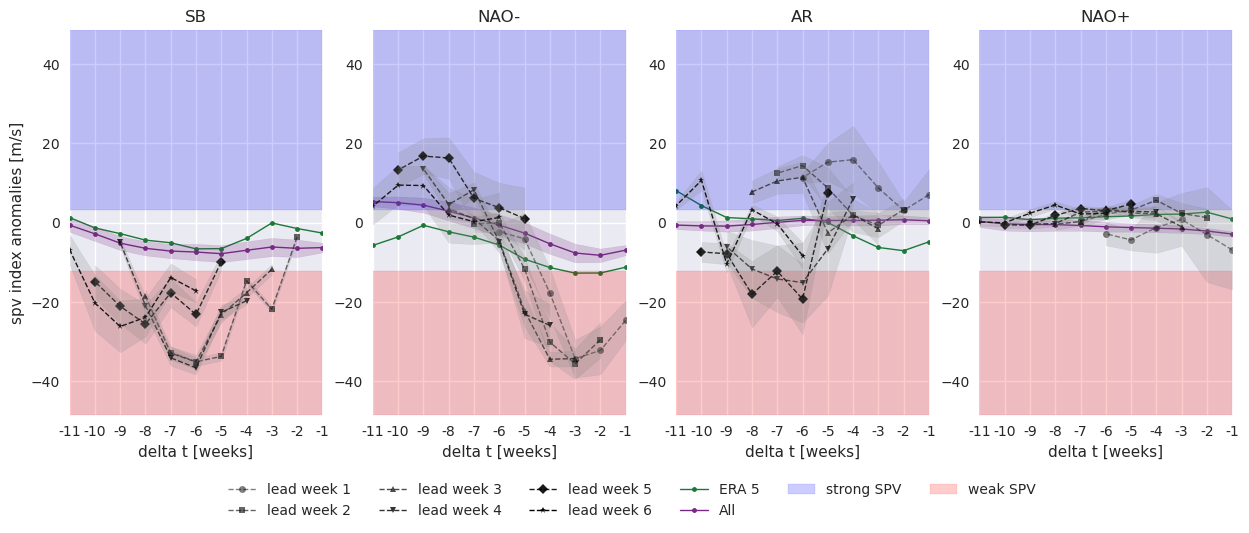

In [124]:
#add mean targets and all predictions
cm_list = ['#7fbf7b','#1b7837','#762a83','#9970ab','#c2a5cf'] 
fig, axes = plt.subplots(1, len(regimes), figsize=(15,5))#, sharex = True)
mult_dt = np.repeat(delta_t[None,:],pv_anom_reg_dt.shape[0], axis= 0)

med_perc = np.nanpercentile(pv_anom_reg_dt[:,:,:].flatten(),30) # upper thresh weak (Tripathi et al. 2015)
strong_perc = np.nanpercentile(pv_anom_reg_dt[:,:,:].flatten(),80) # lower thresh strong (Tripathi et al. 2015)

vmax = np.nanmax(np.abs(pv_anom_reg_dt[:,:,:].flatten()))
delta_t = np.unique(np.array(delta_t_pv[regimes[0]]['delta t']))
delta_t = np.arange(1,delta_t[-1]+1)
colors = sns.color_palette("colorblind", n_colors=6)
alphas = np.linspace(0.5,1, 6)
marker_list = ['o','s','^','v','D','*']

for i, (keys, plot_val_pv) in enumerate(delta_t_pv.items()):
    ax = axes[i]

    plot_data_pv = pv_anom_reg_mean[i]
    plot_uncert_pv = pv_anom_reg_std[i]
    for t in range(plot_data_pv.shape[0]):
        dt = np.flip(np.arange(len(plot_data_pv[t,:]))+t+1)
        ax.plot(np.flip(dt), np.flip(plot_data_pv[t,:]), color='black', marker = marker_list[t], markersize = 5, alpha = alphas[t],
                linestyle='dashed', linewidth=1, zorder=2, label = f'lead week {t+1}')
        # ax.plot(np.flip(dt), np.flip(plot_data_pv[t,:]), color='black', marker = marker_list[t], markersize = 5, alpha = alphas[t],
        #         linestyle='dashed', linewidth=1, zorder=2, label = f'lead week {t+1}')
        ax.fill_between(np.flip(dt), np.flip(plot_data_pv[t,:]) - np.flip(plot_uncert_pv[t,:]), 
                np.flip(plot_data_pv[t,:]) + np.flip(plot_uncert_pv[t,:]), color='grey', alpha=0.2, zorder=2)


    ax.plot(np.flip(delta_t),np.flip(pv_anom_tar_dt_mean[i,:]), color=cm_list[1], linewidth=1, marker = '.', markersize = 7, zorder=1, label = 'ERA 5')
    ax.plot(np.flip(delta_t),np.flip(pv_anom_all_dt_mean[i,:]), color=cm_list[2], linewidth=1, marker = '.', markersize = 7, zorder=1, label = 'All')
    ax.fill_between(np.flip(delta_t), np.flip(pv_anom_all_dt_mean[i,:]) - np.flip(np.sqrt(pv_all_dt_anom_stds[i,:])),
                    np.flip(pv_anom_all_dt_mean[i,:]) + np.flip(np.sqrt(pv_all_dt_anom_stds[i,:])), color=cm_list[2],alpha=0.2, zorder=1)
    # ax.fill_between(np.flip(delta_t), np.flip(pv_anom_tar_dt_mean[i,:]) - np.flip(pv_all_dt_anom_stds[i,:]),
    #                 np.flip(pv_anom_tar_dt_mean[i,:]) + np.flip(pv_all_dt_anom_stds[i,:]), color=cm_list[1], alpha=0.2, zorder=1)
    # pv_anom_tar_dt_std
    # ax.axhline(med_perc, color='red', label = 'weak SPV')
    # ax.axhline(strong_perc, color='blue',label = 'strong SPV')
    # ax.fill_between(np.flip(delta_t), med_perc, strong_perc, color='grey', alpha=0.2, label = 'neutral SPV', zorder=1)
    ax.fill_between(np.flip(delta_t), strong_perc, vmax, color='blue', alpha=0.2, label = 'strong SPV', zorder=1)
    ax.fill_between(np.flip(delta_t), -vmax, med_perc, color='red', alpha=0.2, label = 'weak SPV', zorder=1)
    

    ax.set_ylim(-vmax,vmax)
    ax.set_xlim(np.flip(delta_t)[0], np.flip(delta_t)[-1])
    ax.set_xticks(np.flip(delta_t))
    ax.set_xticklabels(-np.flip(delta_t))
    ax.set_title(f'{keys}')

    ax.set_xlabel(f'delta t [weeks]')
   

axes[0].set_ylabel(f'spv index anomalies [m/s]')
handles, labels = ax.get_legend_handles_labels()
# fig.legend(handles, labels, loc='lower center', ncol=2)
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=6)
fig.savefig(f"{results_directory}/{arch_type}_deltaT_90th_percentile_spvIndex_shifted_dt.png", dpi=600, bbox_inches='tight')              

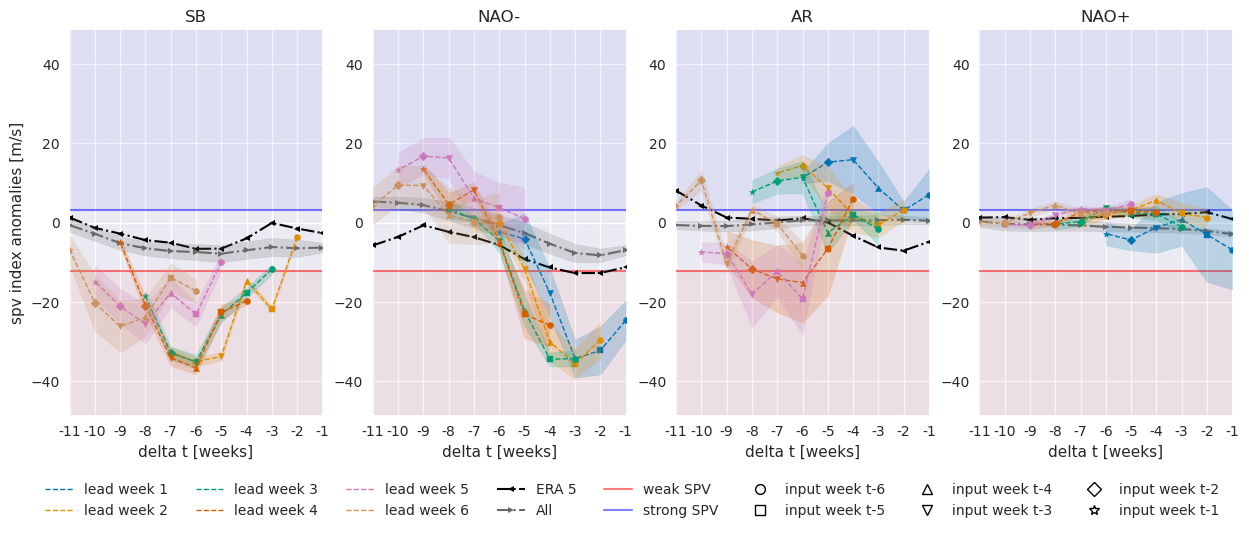

In [125]:
#add mean targets and all predictions
cm_list = ['#7fbf7b','#1b7837','#762a83','#9970ab','#c2a5cf'] 
fig, axes = plt.subplots(1, len(regimes), figsize=(15,5))#, sharex = True)
mult_dt = np.repeat(delta_t[None,:],pv_anom_reg_dt.shape[0], axis= 0)

med_perc = np.nanpercentile(pv_anom_reg_dt[:,:,:].flatten(),30) # upper thresh weak (Tripathi et al. 2015)
strong_perc = np.nanpercentile(pv_anom_reg_dt[:,:,:].flatten(),80) # lower thresh strong (Tripathi et al. 2015)

vmax = np.nanmax(np.abs(pv_anom_reg_dt[:,:,:].flatten()))
delta_t = np.unique(np.array(delta_t_pv[regimes[0]]['delta t']))
delta_t = np.arange(1,delta_t[-1]+1)
colors = sns.color_palette("colorblind", n_colors=6)
alphas = np.linspace(0.5,1, 6)
marker_list = ['o','s','^','v','D','*']
labels_col = []
for i, (keys, plot_val_pv) in enumerate(delta_t_pv.items()):
    ax = axes[i]

    plot_data_pv = pv_anom_reg_mean[i]
    plot_uncert_pv = pv_anom_reg_std[i]
    for t in range(plot_data_pv.shape[0]):
        dt = np.flip(np.arange(len(plot_data_pv[t,:]))+t+1)
        # dt = np.arange(len(plot_data_pv[t,:]))+t+1
        ax.plot(np.flip(dt), np.flip(plot_data_pv[t,:]), color=colors[t], #marker = marker_list[t], markersize = 5,
                zorder=3,linestyle='dashed', linewidth=1, label = f'lead week {t+1}')
        ax.fill_between(np.flip(dt), np.flip(plot_data_pv[t,:]) - np.flip(plot_uncert_pv[t,:]), 
                np.flip(plot_data_pv[t,:]) + np.flip(plot_uncert_pv[t,:]), color=colors[t], alpha=0.2, zorder=3)

        
        dt_flipped = np.flip(dt)
        plot_flipped = np.flip(plot_data_pv[t,:])
        for k in range(len(dt)):
            if t == 0 and i==0:
                labels_col.append(f'input week t{k-6}')
            ax.scatter(dt_flipped[k], plot_flipped[k], color=colors[t], marker = marker_list[k], s = 20,
                zorder=3)

    ax.plot(np.flip(delta_t),np.flip(pv_anom_tar_dt_mean[i,:]), color='black', linestyle = '-.',linewidth=1.5, marker = '<', markersize = 5, zorder=2, label = 'ERA 5')
    ax.plot(np.flip(delta_t),np.flip(pv_anom_all_dt_mean[i,:]), color='dimgray', linestyle = '-.',linewidth=1.5, marker = '>', markersize = 5, zorder=2, label = 'All')
    ax.fill_between(np.flip(delta_t), np.flip(pv_anom_all_dt_mean[i,:]) - np.flip(np.sqrt(pv_all_dt_anom_stds[i,:])),
                    np.flip(pv_anom_all_dt_mean[i,:]) + np.flip(np.sqrt(pv_all_dt_anom_stds[i,:])), color='dimgray',alpha=0.2, zorder=2)
    # ax.fill_between(np.flip(delta_t), np.flip(pv_anom_tar_dt_mean[i,:]) - np.flip(pv_all_dt_anom_stds[i,:]),
    #                 np.flip(pv_anom_tar_dt_mean[i,:]) + np.flip(pv_all_dt_anom_stds[i,:]), color=cm_list[1], alpha=0.2, zorder=1)
    # pv_anom_tar_dt_std
    ax.axhline(med_perc, color='red', label = 'weak SPV', alpha= 0.5,linewidth=1.5, zorder=1)
    ax.axhline(strong_perc, color='blue',label = 'strong SPV', alpha= 0.5,linewidth=1.5, zorder=1)
    # ax.fill_between(np.flip(delta_t), med_perc, strong_perc, color='grey', alpha=0.2, label = 'neutral SPV', zorder=1)
    # ax.fill_between(np.flip(delta_t), strong_perc, vmax, color='blue', alpha=0.2, label = 'strong SPV', zorder=1)
    # ax.fill_between(np.flip(delta_t), -vmax, med_perc, color='red', alpha=0.2, label = 'weak SPV', zorder=1)
    ax.fill_between(np.flip(delta_t), strong_perc, vmax, color='blue', alpha=0.05, zorder=1)
    ax.fill_between(np.flip(delta_t), -vmax, med_perc, color='red', alpha=0.05, zorder=1)
    

    ax.set_ylim(-vmax,vmax)
    ax.set_xlim(np.flip(delta_t)[0], np.flip(delta_t)[-1])
    ax.set_xticks(np.flip(delta_t))
    ax.set_xticklabels(-np.flip(delta_t))
    ax.set_title(f'{keys}')

    ax.set_xlabel(f'delta t [weeks]')
   

axes[0].set_ylabel(f'spv index anomalies [m/s]')
handles, labels = ax.get_legend_handles_labels()
f = lambda m,c: plt.plot([],[],marker=m, markeredgecolor=c, markeredgewidth=1, markerfacecolor="white", ls="none")[0]
handles_row, labels_row = axes[0].get_legend_handles_labels()
handles_row += [f(marker_list[i], "black") for i in range(len(marker_list))]
# fig.legend(handles, labels, loc='lower center', ncol=2)
fig.legend(handles_row, labels_row + labels_col, loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=8)
fig.savefig(f"{results_directory}/{arch_type}_deltaT_90th_percentile_spvIndex_shifted_dt.png", dpi=600, bbox_inches='tight')              

# Mean anomaly MAPS of each regime at each time lag 

In [126]:
idx_t = np.arange(-5,1)
try: 
    loop_u10 = np.repeat(u10[None,:,:,:], loop_classes.shape[0], axis = 0)
except: 
    print('error')



In [127]:
## Climatology and anomalies of spv index
if arch_type == 'ViT':
    regimes = ['SB', 'NAO-', 'AR', 'NAO+']

    sum_u10_reg = np.zeros((len(regimes),loop_u10.shape[3],loop_u10.shape[4]))
    cnt_reg = np.zeros((len(regimes)))


    for i in range(loop_probabilities.shape[0]):
        for j in range(loop_probabilities.shape[1]):
            for k in range(loop_probabilities.shape[2]):
                if loop_probabilities[i,j,k,loop_targets[i,j,k]] > qall_90: 
                    for t in range(pv_inputs.shape[2]):
                        if not np.isnan(pv_inputs[i,j,t]):
                            sum_u10_reg[loop_targets[i,j,k], :,:] += loop_u10[i,j,t,:,:]
                            cnt_reg[loop_targets[i,j,k]] +=1

    avg_u10_reg = sum_u10_reg/np.repeat(np.repeat(cnt_reg[:,None],loop_u10.shape[3], axis =1)[:,:,None],loop_u10.shape[4], axis =2)


    t_in, t_out = pv_inputs.shape[2],loop_probabilities.shape[2]
    sum_spv_img = np.zeros((len(regimes), t_in +t_out-1,loop_u10.shape[3],loop_u10.shape[4]))
    cnt_reg_lag = np.zeros((len(regimes), t_in +t_out-1))
    sum_spv_anom = np.zeros((len(regimes), t_in +t_out-1,loop_u10.shape[3],loop_u10.shape[4]))




    for i in range(loop_probabilities.shape[0]):
        for j in range(loop_probabilities.shape[1]):
            for k in range(loop_probabilities.shape[2]):
                if loop_probabilities[i,j,k,loop_targets[i,j,k]] > qall_90:  
                    for t in range(pv_inputs.shape[2]):
                        if not np.isnan(pv_inputs[i,j,t]):
                            d_t = np.abs((t-5)) + (k+1)
                            sum_spv_anom[loop_targets[i,j,k], d_t-1,:,:] += loop_u10[i,j,t,:,:] - avg_u10_reg[loop_targets[i,j,k],:,:]
                            cnt_reg_lag[loop_targets[i,j,k],d_t-1] +=1
                            sum_spv_img[loop_targets[i,j,k], d_t-1,:,:] += loop_u10[i,j,t,:,:]

    avg_u10_anom = sum_spv_anom/np.repeat(np.repeat(cnt_reg_lag[:,:,None],loop_u10.shape[3], axis =2)[:,:,:,None],loop_u10.shape[4], axis =3)
    avg_u10_img = sum_spv_img/np.repeat(np.repeat(cnt_reg_lag[:,:,None],loop_u10.shape[3], axis =2)[:,:,:,None],loop_u10.shape[4], axis =3)


In [128]:
## Image Plots: U10
if arch_type == 'ViT':
    import cartopy.crs as ccrs


    u_10 = xr.open_dataset('/mnt/beegfs/home/bommer1/WiOSTNN/Version1/data/ERA5/datasets/u_10_1.40625deg_1980-2023_spv_2d.nc')

    proj = ccrs.NorthPolarStereo() #AzimuthalEquidistant()
    kwtrans = dict(central_latitude=90, central_longitude=0.)
    trans = ccrs.Stereographic(**kwtrans)
    fig, axes = plt.subplots(loop_probabilities.shape[2]*2-1, len(regimes), figsize = (8,20),#figsize=(20,12),
                            sharex = True, sharey = True, subplot_kw={'projection': proj}) #, sharey = True

    lead_time = np.arange(-6,6)
    extent = (u_10.lon.min(), u_10.lon.max(), u_10.lat.min(), u_10.lat.max())

    ds_u10 = xr.DataArray(
        data=avg_u10_anom,
        dims=['regimes', 'leadtime','lat', 'lon'],
        coords=dict(
            lat = u_10.lat.values, #
            lon= u_10.lon.values, 
            leadtime= delta_t,
            regimes = regimes,
        ),
    )
    vmax  = abs(ds_u10).max().values

    for r, reg in enumerate(regimes):
        for i in range(len(delta_t)):
        
            ax = axes[i,r]

            ds_plot = ds_u10[r,i,:,:]

            g = ax.imshow(ds_plot, vmin = -vmax, vmax = vmax, extent=extent, origin='lower', cmap=plt.cm.RdBu_r, transform=ccrs.PlateCarree())
            ax.coastlines()
            ax.set_extent([u_10.lon.min(), u_10.lon.max(), u_10.lat.min(), u_10.lat.max()], ccrs.PlateCarree())

            if i == 0:
                ax.set_title(f'{reg}', fontsize=16)
            # if r == 0:
            #     ax.set_ylabel(f'delta t = {delta_t[i]} weeks')
            
    # Add column annotations for delta_t
    for i in range(len(delta_t)):
        if i == 0:
            axes[i, 0].annotate(f'{delta_t[i]} week\n', xy=(0, 0.2), xycoords='axes fraction', ha='center', 
                                fontsize=16,rotation=90)
        else:
            axes[i, 0].annotate(f'{delta_t[i]} weeks\n', xy=(0, 0.2), xycoords='axes fraction', ha='center', 
                                fontsize=16, rotation=90)
    # add space for colour bar
    # fig.colorbar(g, ax=axes[-1, :], orientation='horizontal', label='anomalies', location='bottom') #shrink=0.8,
    # fig.colorbar(g, ax=axes[:, -1], label='anomalies', shrink=0.4)
    fig.subplots_adjust(right=0.90)
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(g, cax=cbar_ax, shrink=0.8)
    cbar.set_label('anomalies', fontsize=16)

    fig.savefig(f"{results_directory}/leadtime_regime_anomaliesSPV.png", dpi=600, bbox_inches='tight')



In [129]:
## Image Plots: U10
import cartopy.crs as ccrs

# class cartopy.crs.NorthPolarStereo(central_longitude=0.0, globe=None)
if arch_type == 'ViT':
    u_10 = xr.open_dataset('/mnt/beegfs/home/bommer1/WiOSTNN/Version1/data/ERA5/datasets/u_10_1.40625deg_1980-2023_spv_2d.nc')

    # proj = ccrs.PlateCarree() #other projection -> orthographic or NorthPolar stereo
    proj = ccrs.NorthPolarStereo() #AzimuthalEquidistant()
    kwtrans = dict(central_latitude=90, central_longitude=0.)
    trans = ccrs.Stereographic(**kwtrans)
    fig, axes = plt.subplots( loop_probabilities.shape[2]*2-1, len(regimes), figsize = (9,20),#figsize=(20,12),
                            sharex = True, sharey = True, subplot_kw={'projection': proj}) #, sharey = True

    lead_time = np.arange(-6,6)
    extent = (u_10.lon.min(), u_10.lon.max(), u_10.lat.min(), u_10.lat.max())

    ds_u10 = xr.DataArray(
        data=np.array(avg_u10_img),
        dims=['regimes', 'leadtime','lat', 'lon'],
        coords=dict(
            lat = u_10.lat.values, #
            lon= u_10.lon.values, 
            leadtime= delta_t,
            regimes = regimes,
        ),
    )
    vmax  = abs(ds_u10).max().values

    for r, reg in enumerate(regimes):
        for i in range(len(delta_t)):
        
            ax = axes[i,r]

            ds_plot = ds_u10[r,i,:,:]

            g = ax.imshow(ds_plot, vmin = -vmax, vmax = vmax, extent=extent, origin='lower', cmap=plt.cm.RdBu_r, transform=ccrs.PlateCarree())
            ax.coastlines()
            ax.set_extent([u_10.lon.min(), u_10.lon.max(), u_10.lat.min(), u_10.lat.max()], ccrs.PlateCarree())

            if i == 0:
                ax.set_title(f'{reg}')
            # if r == 0:
            #     ax.set_ylabel(f'delta t = {delta_t[i]} weeks')
            
    # Add column annotations for delta_t
    for i in range(len(delta_t)):
        if i == 0:
            axes[i, 0].annotate(f'{delta_t[i]} week\n', xy=(0, 0.2), xycoords='axes fraction', ha='center', 
                                fontsize=12,rotation=90)
        else:
            axes[i, 0].annotate(f'{delta_t[i]} weeks\n', xy=(0, 0.2), xycoords='axes fraction', ha='center', 
                                fontsize=12, rotation=90)
    # add space for colour bar
    # fig.colorbar(g, ax=axes[-1, :], orientation='horizontal', label='anomalies', location='bottom') #shrink=0.8,
    # fig.colorbar(g, ax=axes[:, -1], label='anomalies', shrink=0.4)
    fig.subplots_adjust(right=0.90)
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(g, cax=cbar_ax, shrink=0.8)
    cbar.set_label('anomalies', fontsize=16)

    fig.savefig(f"{results_directory}/leadtime_regime_SPV.png", dpi=600, bbox_inches='tight')

